In [105]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

In [116]:
def surface_area(v, f):
    def triangle_area(face):
        i, j, k = face
        return 0.5 * jnp.linalg.norm(jnp.cross(v[j]-v[i], v[k]-v[i]))
    return jnp.sum(jax.vmap(triangle_area)(f))

In [117]:
def minimize(loss, x, c, step_size, num_steps):
    @jax.jit
    def update(x):
        g = jax.grad(loss)(x)
        constrained_g = g.at[c].set(0.)
        return x - step_size * constrained_g
    for i in range(num_steps):
        x = update(x)
    return x

In [174]:
def make_cylinder_triangulation(ni=3, nj=3, periodic_j=True):
    i, j = np.meshgrid(np.arange(ni-1), np.arange(nj-1))
    triangles = np.concatenate([
        np.stack([i*ni+j, i*ni+j+1,   (i+1)*ni+j+1], axis=-1),
        np.stack([i*ni+j, (i+1)*ni+j, (i+1)*ni+j+1], axis=-1),
    ]).reshape(-1, 3)
    if periodic_j: # glue opposite sides
        i = np.arange(nj-1)
        wrap = np.concatenate([
            np.stack([i*ni+nj-1,          i*ni, (i+1)*ni], axis=-1),
            np.stack([i*ni+nj-1, (i+1)*ni+nj-1, (i+1)*ni], axis=-1),
        ])
        triangles = np.concatenate([triangles, wrap])
    return triangles

a = jnp.linspace(0, 2*jnp.pi, num=100)
b = jnp.linspace(0, 4, num=100)
faces = make_cylinder_triangulation(len(b), len(a))
a, b = jnp.meshgrid(a, b)
a, b = a.flatten(), b.flatten()

In [175]:
## constrain top and bottom row only
# c = jnp.where((b == b.min()) | (b == b.max()))[0]

# constrain vertices close to top and bottom
c = jnp.where((jnp.abs(b - b.min()) < 0.05) | (jnp.abs(b - b.max()) < 0.05))[0]

In [176]:
## cylinder
# x = jnp.cos(a)
# y = jnp.sin(a)
# z = b

# star
s = 3 + jnp.sin(5*a)
x = s * jnp.cos(a)
y = s * jnp.sin(a)
z = b

v = jnp.vstack((x, y, z)).T
v.shape, faces.shape, c.shape

((10000, 3), (19800, 3), (400,))

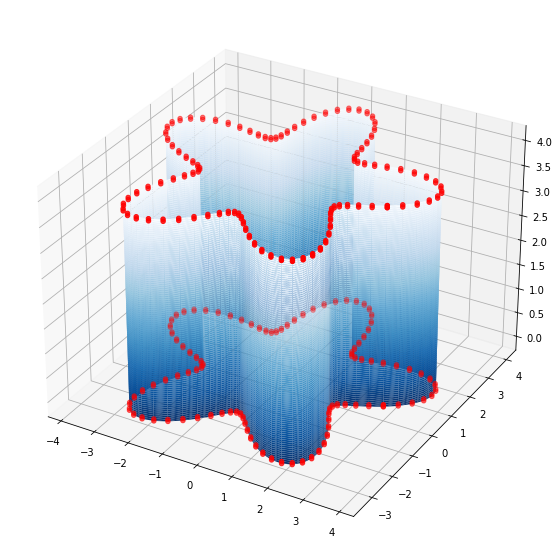

In [177]:
def plot_mesh(v, f, c=None):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.plot_trisurf(v[:,0], v[:,1], v[:,2], triangles=faces, cmap=plt.cm.Blues_r)
    ax.scatter3D(v[c,0], v[c,1], v[c,2], c="red")
    plt.close()
    return fig

plot_mesh(v, f, c)

In [178]:
v2 = minimize(lambda v: surface_area(v, faces), v, c, step_size=1e-1, num_steps=10000)

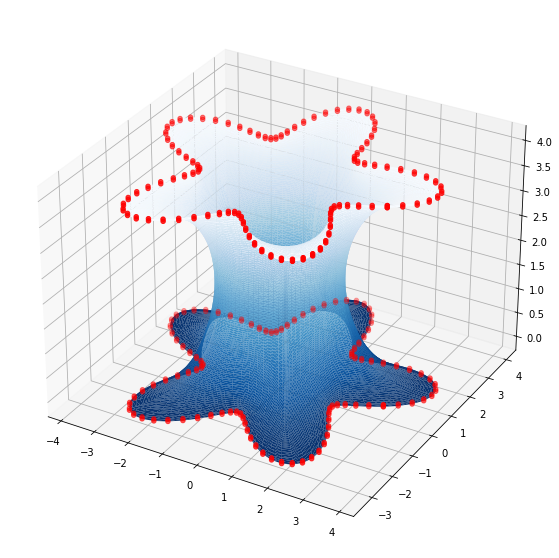

In [179]:
plot_mesh(v2, f, c)